# Kapetyn Murnane Labs Ptychography Reconstruction Workflow

This will use an output file from the simulation workflow.

In [1]:
import ptypy
from ptypy import utils as u
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os

p = u.Param()
p.verbose_level = 2
p.data_type = "single"

p.scans = u.Param()
p.scans.KM = u.Param()
p.scans.KM.name = 'Full'
p.scans.KM.data = u.Param()
#p.scans.KM.data.name = 'NumpyScan'
p.scans.KM.data.name = 'MoonFlowerScan'
p.scans.KM.data.shape = 256
p.scans.KM.data.num_frames = 116
#p.scans.KM.data.save = 'append'
p.scans.KM.data.load_parallel = 'all'

#^should I make a param file override numpy settings?
#p.scans.KM.data.base_path = 'C:\\Users\\jspott\\Desktop\\SimulationData\\2019-09-24--10-34-00'
#p.scans.KM.data.base_path='C:\\Users\\Public\\Documents\\Ptychography\\Simulations\\basic_simulation_moon_probe1'
#^This is the only thing that should need changing!

#meta = pickle.load(open(p.scans.KM.data.base_path+'\\meta.p'))
recons_subscript = 'histogram_no-slicing_vmax-None_without-probe_probe&obj-comparisons_std_NO-INIT-OBJ'
#rootDir = os.path.join(p.scans.KM.data.base_path, 'Reconstruction_' + recons_subscript)
rootDir = os.path.join('C:\\Users\\Public\\Documents\\Ptychography\\Simulations\\basic_simulation_moon_probe1', 'Reconstruction_' + recons_subscript)

os.mkdir(rootDir)

p.scans.KM.data.dfile = os.path.join(rootDir, 'dfile') 


#default:
"""
p.scans.KM.data.name = 'MoonFlowerScan'
p.scans.KM.data.shape = 128
p.scans.KM.data.num_frames = 400
"""

P = ptypy.core.Ptycho(p, level=2)

diff_storage = P.diff.storages.values()[0]
fig = u.plot_storage(diff_storage, 0, slices=(slice(2), slice(None), slice(None)), modulus='log')
fig.savefig('recons_diffraction_sanity_check.png', dpi=300)

WARNING root - Failed registering instance of <class 'ptypy.core.ptycho.Ptycho'> with ID Ptycho to object None
WARNING root - Failed registering instance of <class 'ptypy.core.geometry.Geo'> with ID None to object None


In [2]:
#this is the engine

def fourier_update(pods):
    import numpy as np
    pod = pods.values()[0]
    # Get Magnitude and Mask
    mask = pod.mask
    modulus = np.sqrt(np.abs(pod.diff))
    # Create temporary buffers
    Imodel = np.zeros_like(pod.diff)
    err = 0.
    Dphi = {}
    # Propagate the exit waves
    for gamma, pod in pods.iteritems():
        Dphi[gamma] = pod.fw(2*pod.probe*pod.object - pod.exit)
        Imodel += np.abs(Dphi[gamma] * Dphi[gamma].conj())
    # Calculate common correction factor
    factor = (1-mask) + mask * modulus / (np.sqrt(Imodel) + 1e-10)
    # Apply correction and propagate back
    for gamma, pod in pods.iteritems():
        df = pod.bw(factor*Dphi[gamma]) - pod.probe*pod.object
        pod.exit += df
        err += np.mean(np.abs(df*df.conj()))
    # Return difference map error on exit waves
    return err

def probe_update(probe, norm, pods, fill=0.):
    """
    Updates `probe`. A portion `fill` of the probe is kept from
    iteration to iteration. Requires `norm` buffer and pod dictionary
    """
    probe *= fill
    norm << fill + 1e-10
    for name, pod in pods.iteritems():
        if not pod.active: continue
        probe[pod.pr_view] += pod.object.conj() * pod.exit
        norm[pod.pr_view] += pod.object * pod.object.conj()
    # For parallel usage (MPI) we have to communicate the buffer arrays
    probe.allreduce()
    norm.allreduce()
    probe /= norm

def object_update(obj, norm, pods, fill=0.):
    """
    Updates `object`. A portion `fill` of the object is kept from
    iteration to iteration. Requires `norm` buffer and pod dictionary
    """
    obj *= fill
    norm << fill + 1e-10
    for pod in pods.itervalues():
        if not pod.active: continue
        pod.object += pod.probe.conj() * pod.exit
        norm[pod.ob_view] += pod.probe * pod.probe.conj()
    obj.allreduce()
    norm.allreduce()
    obj /= norm

def iterate(Ptycho, num):
    # generate container copies
    obj_norm = P.obj.copy(fill=0.)
    probe_norm = P.probe.copy(fill=0.)
    errors = []
    for i in range(num):
        err = 0
        # fourier update
        for di_view in Ptycho.diff.V.itervalues():
            if not di_view.active: continue
            err += fourier_update(di_view.pods)
        # probe update
        probe_update(Ptycho.probe, probe_norm, Ptycho.pods)
        # object update
        object_update(Ptycho.obj, obj_norm, Ptycho.pods)
        # print error
        errors.append(err)
        if i % 3==0: print err
    # cleanup
    P.obj.delete_copy()
    P.probe.delete_copy()
    #return error
    return errors


In [3]:
image_path = os.path.join(rootDir, 'images')
os.mkdir(image_path)

probe_storage = P.probe.storages.values()[0]
#fig = u.plot_storage(P.probe.S.values()[0], 1)
#fig.savefig('std_probe.png', dpi=300)
# Plot of the starting guess for the probe.

#This changes the probe to the probe that's loaded in the ptyscan (numpyscan)
#probe_storage.fill(P.model.scans.values()[0].ptyscan.pr)

fig = u.plot_storage(P.probe.S.values()[0], 1)
fig.savefig(image_path + '\\init_probe.png', dpi=300)

#the slices argument is absolutely essential here to make this work. I think this can be 
# constructed from P.p.num_frames...
#fig = u.plot_storage(P.obj.S.values()[0], 201)
#fig = u.plot_storage(P.obj.S.values()[0], 2)
#fig.savefig(image_path + '\\init_obj.png', dpi=300)

plt.close('all')

iterations = 40
for i in range(4,4*iterations+4,4):
    iterate(P, 1)
    fig = u.plot_storage(P.probe.S.values()[0], i/4-1,channel = 'c', modulus = 'linear', vmax = None)
    fig.savefig(image_path + '\\probe_complex_iteration_%d.png' % (i/4), dpi=300)
    
    fig = u.plot_storage(P.probe.S.values()[0], i/4)
    fig.savefig(image_path + '\\probe_iteration_%d.png' % (i/4), dpi=300)
    
    fig = u.plot_storage(P.obj.S.values()[0],i/4+1, vmax = None)
    #fig = u.plot_storage(P.obj.S.values()[0], 1+i)
    fig.savefig(image_path + '\\object_real_iteration_%d.png' % (i/4), dpi=300)
    
    fig = u.plot_storage(P.obj.S.values()[0],i/4+2, channel = 'c', modulus = 'linear', vmax = None)
    #fig = u.plot_storage(P.obj.S.values()[0], 1+i)
    fig.savefig(image_path + '\\object_complex_iteration_%d.png' % (i/4), dpi=300)
    """
    fig = u.plot_storage(P.obj.S.values()[0],1000*i+1, modulus = 'log')
    #fig = u.plot_storage(P.obj.S.values()[0], 1+i)
    fig.savefig(image_path + '\\object_log_%d.png' % (i/2), dpi=300)
    
    fig = u.plot_storage(P.obj.S.values()[0],10000*i+1, modulus = 'sqrt')
    #fig = u.plot_storage(P.obj.S.values()[0], 1+i)
    fig.savefig(image_path + '\\object_sqrt_%d.png' % (i/2), dpi=300)
    
    image_array = P.obj.S.values()[0].data
    plt.close('all')
    plt.hist(image_array.flatten(),100,[0,10])
    plt.savefig(image_path + '\\histogram_iteration_{}'.format(i/2), dpi=300)
    """
    plt.close('all')


38830.0085599
20136.9319371
37007.0705391
45616.5464204
45868.0251382
42944.7560879
38993.356842
34967.9538198
31216.8162069
27659.5128436
24970.7216035
22842.1461671
21464.3495869
20133.1842224
18619.0327916
17037.0335369
15644.7878097
13746.1697273
11890.1882367
9965.79433309
8418.99348074
7243.38894224
6357.05974578
5662.51225013
5018.70159725
4403.22171877
3764.89948089
3060.57615947
2646.79763284
2244.61357036
1929.86510716
1675.5889453
1485.08558969
1340.70271702
1235.57469666
1144.24526699
1088.39993997
1053.54429672
1033.81708346
1022.39464375


In [4]:
print(P.obj.S.values()[0].data.shape)
P.obj.S.values()[0].data
print(P.obj.S.values()[0].data[0,120:-120,120:-120].shape)

import numpy as np
slc = eval('np.index_exp[slice(1),slice(None),slice(None)]')
print(slc)
print(P.obj.S.values()[0].data[slc].shape)

#image_array = P.obj.S.values()[0].data
#image_array
#plt.hist(image_array)

(1L, 868L, 870L)
(628L, 630L)
(slice(None, 1, None), slice(None, None, None), slice(None, None, None))
(1L, 868L, 870L)


<IPython.core.display.Javascript object>


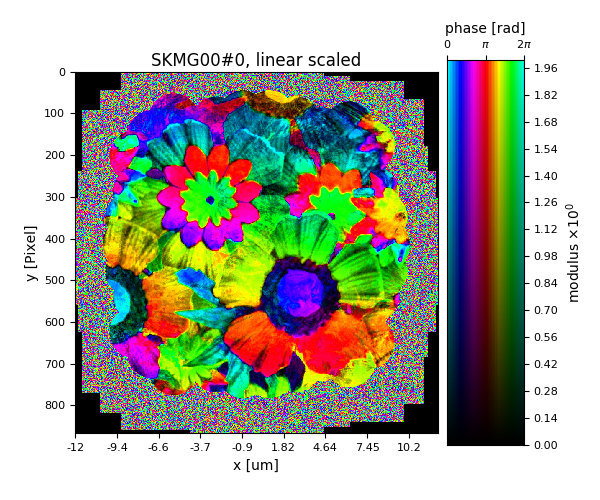

In [8]:
%matplotlib notebook
#plt.hist(image_array.flatten(),256,[0,50])
#plt.show
plt.close('all')
channel = 'c'
fig = u.plot_storage(P.obj.S.values()[0],i+1001, vmax = 2)
#fig = u.plot_storage(P.obj.S.values()[0], 1+i)
fig.savefig(image_path + '\\object_iteration_{0}_channel-{1}.png'.format(i/2,channel), dpi=300)
    